# DQN-Ram

## Features
* Discrete action space
* Input: length of state space (1D state)
* Ouput: length of action space
* Target network
* Replay buffer

## Test env
* InvertedPendulumMuJoCoEnv-v0 **[Solved]**
* HalfCheetahMuJoCoEnv-v0 **[Solved]**
* Breakout-ram-v4 **[Better than random]**


In [1]:
# load gym envs and common functions
from utils import *

In [2]:
# Sample tuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# ReplayBuffer
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    
# DQN
# Discrete action space and 1D state vector
class DQNRam:
    def __init__(self, net, opt, actions, device, gamma=0.99):
        self.name = "DQNRam"
        self.policy = net
        self.target = copy.deepcopy(net) # add target network
        self.opt = opt
        self.gamma = gamma
        self.actions = actions
        self.device = device
        
    def load(self, data):
        self.policy.load_state_dict(data['policy'])
        self.target.load_state_dict(data['target'])
        
    def save(self):
        return {'policy': self.policy.state_dict(),
                'target': self.target.state_dict()}
    
    def prep(self, s):
        return torch.from_numpy(s).float().view(1, -1).to(self.device)
    
    def forward(self, s):
        with torch.no_grad():
            return self.policy(self.prep(s)).max(1)[1][0]

    def e_greedy(self, s, epsilon):
        action_len = len(self.actions)
        p = np.ones(action_len) * epsilon / action_len
        p[self.forward(s)] += 1 - epsilon
        return np.random.choice(action_len, p=p)
        
    def best(self, s):
        return self.actions[self.forward(s)]
    
    # copy policy network to target network
    def update(self):
        self.target.load_state_dict(self.policy.state_dict())
        
    def train(self, transitions):
        s, a, r, sp, done = zip(*transitions)
        
        s = torch.cat([self.prep(i) for i in s], axis=0).to(self.device) # m * n
        sp = torch.cat([self.prep(i) for i in sp], axis=0).to(self.device) # m * n
        r = torch.Tensor([r]).view(-1, 1).to(self.device)
        a = torch.Tensor([a]).long().view(-1, 1).to(self.device)
        done = torch.Tensor([done]).view(-1, 1).to(self.device) 
        
        with torch.no_grad():
            next_q = self.target(sp).max(1)[0].unsqueeze(1)
        target_q = r + self.gamma * next_q * (1 - done)

        current_q = self.policy(s).gather(1, a)
        loss = F.mse_loss(current_q, target_q)
        
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()


def dqn_ram_learning(env_name, agent, config, seed=0):
    set_seeds(seed)
    
    # init env
    env = gym.make(env_name)
    print("Env:", env_name)
    print("Action space:", env.action_space)
    print("Obs space:", env.observation_space)
    print("Agent:", agent.name)
    
    epoch, rewards, max_reward = load_state(env_name, agent)
    print(f"Start at epoch {epoch}, max_reward: {max_reward}")
    
    # init replay buffer
    memory = ReplayBuffer(config.get('buffer_size', 50000))
    batch_size = config.get('batch_size', 32)
    
    # epsilon decay
    epsilon_min = config.get('epsilon_min', 0.1)
    epsilon_discount = config.get('epsilon_discount', 0.99)
    epsilon = config.get('epsilon_max', 0.5) * pow(epsilon_discount, epoch)
    
    # update network count
    train_count = 0
    
    # start training and test
    while epoch < config.get('max_epoch', 5000):
        try:
            loss = []
            
            # learning
            obs = env.reset()
            for i in range(config.get('max_step', 1000)):
                s = obs.ravel()
                a = agent.e_greedy(s, epsilon)
                # One step
                obs, r, done, _ = env.step(agent.actions[a])
                # push to replay buffer
                memory.push(s, a, r, obs.ravel(), 1 if done else 0)
                
                # check for training
                if len(memory) >= batch_size and i % config.get('learn_interval', 4) == 0:
                    loss_ = agent.train(memory.sample(batch_size))
                    loss.append(loss_)
                    train_count += 1
                
                # check for update target network
                if train_count > config.get('update_interval', 100):
                    agent.update()
                    train_count = 0
                
                if done:
                    break

            # test
            test_reward = 0
            obs = env.reset()
            for i in range(config.get('max_step', 1000)):
                s = obs.ravel()
                a = agent.best(s)
                obs, r, done, _ = env.step(a)
                test_reward += r
                if done:
                    break
            
            # save reward
            rewards.append(test_reward)
            if len(loss):
                print(f"Epoch {epoch} | Epsilon: {epsilon:.3f} | Buffer: {len(memory)} | Avg loss: {np.mean(loss)} | Test reward: {test_reward:.1f}")
            else:
                print(f"Epoch {epoch} | Epsilon: {epsilon:.3f} | Buffer: {len(memory)} | Test reward: {test_reward:.1f}")
            
            # save states
            if test_reward >= max_reward or epoch % config.get('save_interval', 100) == 0:
                max_reward = max(test_reward, max_reward)
                save_state(env_name, agent, f'-{epoch}', epoch, rewards)
                
            # epsilon decay
            epsilon *= epsilon_discount
            epsilon = max(epsilon_min, epsilon)
            
            epoch += 1
        except KeyboardInterrupt:
            break
        except:
            traceback.print_exc()
            break
    save_state(env_name, agent, '', epoch, rewards)
    # clean up
    env.close()
    # plot rewards
    draw_training_rewards(f"{agent.name} - {env_name}", rewards, config['plt_smooth'])

###  Env 1 InvertedPendulumMuJoCoEnv-v0

In [3]:
# Initialize network, optimizer and agent

config = {
    "save_interval": 500,
    "update_interval": 100,
    "learn_interval": 5,
    "max_epoch": 10000,
    "max_step": 1000,
    "epsilon_max": 0.5, # e-greedy
    "epsilon_min": 0.1,
    "epsilon_discount": 0.999, 
    "gamma": 0.9,   # discount factor
    "lr": 0.0001,    # learning rate
    "buffer_size": 5000,
    "batch_size": 128,
    "plt_smooth": 1,
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 3-layer FC network
from model.FCN3 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[-1], [0], [1]]
net = FCN3(4, len(actions), 32).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = DQNRam(net, opt, actions, device, gamma=config['gamma'])

In [ ]:
# train agent
dqn_ram_learning("InvertedPendulumMuJoCoEnv-v0", agent, config)

options= 
Test DQNRam at epoch 4321, max_reward: 1000.0
options= 
Test 1 | Step: 1000 | Test reward: 1000.0
Test 2 | Step: 1000 | Test reward: 1000.0
Test 3 | Step: 1000 | Test reward: 1000.0
Test 4 | Step: 1000 | Test reward: 1000.0
Test 5 | Step: 1000 | Test reward: 1000.0
Test 6 | Step: 1000 | Test reward: 1000.0
Test 7 | Step: 1000 | Test reward: 1000.0
Test 8 | Step: 1000 | Test reward: 1000.0
Test 9 | Step: 1000 | Test reward: 1000.0
Test 10 | Step: 1000 | Test reward: 1000.0
Mean reward: 1000.0.


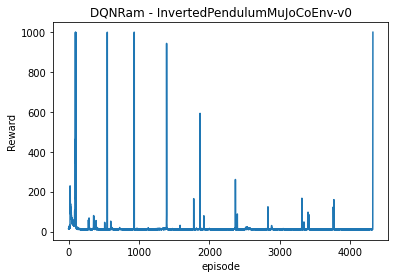

In [5]:
# evaluate agent
evaluate_agent("InvertedPendulumMuJoCoEnv-v0", agent, config)

###  Env 2 HalfCheetahMuJoCoEnv-v0

In [6]:
config = {
    "save_interval": 500,
    "update_interval": 1000,
    "learn_interval": 10,
    "max_epoch": 50000,
    "max_step": 200,
    "epsilon_max": 0.5, # e-greedy
    "epsilon_min": 0.1,
    "epsilon_discount": 0.9999, 
    "gamma": 0.99,   # discount factor
    "lr": 0.00001,   # learning rate
    "buffer_size": 5000,
    "batch_size": 32,
    "plt_smooth": 1,    #
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 5-layer FC network
from model.FCN5 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[j1, j2, j3, j4, j5, j6] for j1 in range(-1, 2)
           for j2 in range(-1, 2)
           for j3 in range(-1, 2)
           for j4 in range(-1, 2)
           for j5 in range(-1, 2)
           for j6 in range(-1, 2)]
net = FCN5(17, len(actions), 128).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = DQNRam(net, opt, actions, device, gamma=config['gamma'])

In [ ]:
# train agent
dqn_ram_learning("HalfCheetahMuJoCoEnv-v0", agent, config)

WalkerBase::__init__
options= 
Test DQNRam at epoch 17000, max_reward: 165.9775794728209
options= 
Test 1 | Step: 1000 | Test reward: 685.4
Test 2 | Step: 1000 | Test reward: 722.7
Test 3 | Step: 1000 | Test reward: 728.2
Test 4 | Step: 1000 | Test reward: 497.7
Test 5 | Step: 1000 | Test reward: 692.4
Test 6 | Step: 1000 | Test reward: 673.0
Test 7 | Step: 1000 | Test reward: 501.6
Test 8 | Step: 1000 | Test reward: 738.4
Test 9 | Step: 1000 | Test reward: 669.8
Test 10 | Step: 1000 | Test reward: 679.9
Mean reward: 658.9.


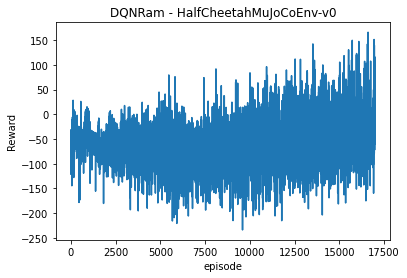

In [18]:
# test agent
evaluate_agent("HalfCheetahMuJoCoEnv-v0", agent, config)

###  Env 3 Breakout-ram-v4

In [3]:
# Initialize network, optimizer and agent

config = {
    "save_interval": 500,
    "update_interval": 100,
    "learn_interval": 10,
    "max_epoch": 100000,
    "max_step": 1000,
    "epsilon_max": 0.5, # e-greedy
    "epsilon_min": 0.1,
    "epsilon_discount": 0.999, 
    "gamma": 0.99,   # discount factor
    "lr": 0.0001,    # learning rate
    "buffer_size": 5000,
    "batch_size": 32,
    "plt_smooth": 1,
    "test_max_epoch": 10,
    "test_max_step": 1000,
}

# load 5-layer FC network
from model.FCN5 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = [[0], [1], [2], [3]]
net = FCN5(128, len(actions), 128).to(device)
opt = torch.optim.RMSprop(net.parameters(), lr=config['lr'])
agent = DQNRam(net, opt, actions, device, gamma=config['gamma'])

def normalized_prep(self, s):
    val = torch.from_numpy(s).float() / 255
    return val.view(1, -1).to(self.device)

import types
agent.prep=types.MethodType(normalized_prep, agent)
        

In [ ]:
# train agent
dqn_ram_learning("Breakout-ram-v4", agent, config)

Test DQNRam at epoch 80481, max_reward: 18.0
Test 1 | Step: 998 | Test reward: 6.0
Test 2 | Step: 964 | Test reward: 5.0
Test 3 | Step: 804 | Test reward: 2.0
Test 4 | Step: 1000 | Test reward: 6.0
Test 5 | Step: 430 | Test reward: 7.0
Test 6 | Step: 833 | Test reward: 8.0
Test 7 | Step: 521 | Test reward: 6.0
Test 8 | Step: 446 | Test reward: 5.0
Test 9 | Step: 853 | Test reward: 7.0
Test 10 | Step: 407 | Test reward: 4.0
Mean reward: 5.6.


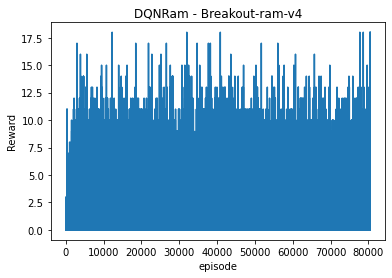

In [4]:
# evaluate agent
evaluate_agent("Breakout-ram-v4", agent, config)